<a href="https://colab.research.google.com/github/katyasmpsn/alethea_interview/blob/main/Alethea_TakeHome_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alethea Take Home Test 
## Katya Simpson 

Please use the Table of Contents for easy navigation! If running code please enable a GPU runtime. 

I approached this as a topic modeling problem. My full report is linked at the end of the notebook. 

1.   Use the BerTopic library to find clusters of sentence embeddings that can be construed as topics. I justify why I use this 3rd-party library in the report
2.   Compare the topics from (1) to the topics found using LDA as a gut-check 
3.   Perform a quick analysis of topic changes/prevalence over time to start to approach the client's request of understanding the nature of the conversation 


## Preprocessing 

This section should only be run once: it outputs `cleaned_tokens.csv` with preprocessed data that will be read in after this step. 

In [ ]:
# Boilerplate and Imports

#Run the following limes *once* for a new colab instance 
!pip install bertopic[visualization]
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

import re
import string
import ast
import random
import gensim
import nltk

import pandas as pd
import numpy as np
import seaborn as sns

from bertopic import BERTopic
from gensim import corpora, models
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 KB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 97.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 104.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 77.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Reading in data
df_biden = pd.read_csv("/content/hashtag_joebiden.csv", lineterminator='\n')
df_trump = pd.read_csv("/content/hashtag_donaldtrump.csv",  lineterminator='\n')

def textCleaning(rawtext):
    """
    Input: Raw text from tweet
    Output: A string (if joined=True, an array if not) of lowercased tokens with usernames, hashtags, urls, stopwords, and digits omitted
    """
    tt = TweetTokenizer()

    tokens = tt.tokenize(rawtext)
    tokens = [x.lower() for x in tokens]

    hashtag_pattern = (
        r"\b[a-z]"  # first member would fail on hashtags, digits, usernames
    )
    # line below from https://stackoverflow.com/questions/6038061/regular-expression-to-find-urls-within-a-string
    url_pattern = r"(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])"

    tokens = [x for x in tokens if re.search(hashtag_pattern, x[0])]
    tokens = [x for x in tokens if not re.search(url_pattern, x)]

    # taking out all punctuation
    tokens = [s.translate(str.maketrans("", "", string.punctuation)) for s in tokens]

    # removing empty strings
    tokens = [i for i in tokens if i]

    return tokens 

df = pd.concat([df_biden, df_trump]) 
df = df[["tweet", "created_at", "country", "likes"]]

df["tweet"] = df["tweet"].apply(textCleaning)

df["tweet"] = df["tweet"].apply(lambda x: gensim.parsing.preprocessing.remove_stopwords(" ".join(x)))

# Could have identified/omitted non-English tweets at this point, however 
# because BerTopic accepts multilinqual pre-trained models it is not 
# necessary. 

df.to_csv("cleaned_strings.csv")


In [ ]:
# release dataframe local memory 
lst = [df]
del lst 

## Using BerTopic to find topics 

In [ ]:
df = pd.read_csv("/content/cleaned_strings.csv")



In [ ]:
# generating sentence embeddings for all the tweets would be 
# very compute-expensive (and this exercise is meant to be completed
# in 2 hours). I randomly select a one-fifth of
# the dataset to model. 

N = len(df)
N_s = round(N/5)
sampled = df.sample(n = N_s)
print(N,N_s)

# Need to create strings from token lists. Note that 
# we save them as token lists initially because the 
# data from cleaned_data.csv will also be used for LDA
# later 

# res = []
# for lst in sampled["tweet"].tolist():
#     joined_str = ' '.join(ast.literal_eval(lst))
#     res.append(joined_str)

res = sampled.tweet.tolist()
res = [x for x in res if x == x]

1747805 349561


In [ ]:
# initializing and running BerTopic. 
# Choosing a multilingual model and setting the number of
# topics to 50 (otherwise thousands of clusters will be generated
# and interpretability would suffer)
model = BERTopic(language="multilingual", nr_topics=50, verbose = True)
topics, probabilities = model.fit_transform(res)

Batches:   0%|          | 0/9737 [00:00<?, ?it/s]

2023-03-08 00:32:55,142 - BERTopic - Transformed documents to Embeddings
2023-03-08 00:43:12,012 - BERTopic - Reduced dimensionality
2023-03-08 00:43:55,911 - BERTopic - Clustered reduced embeddings
2023-03-08 00:44:24,388 - BERTopic - Reduced number of topics from 3178 to 50


In [ ]:
model.save("ks_model")


/usr/local/lib/python3.8/dist-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
sampled.to_csv("sampled_data.txt")

In [ ]:
# loading the model if I need to 
# model = BERTopic.load("ks_model")


### Analysis of BERTopic topics

A high proportion of the documents were mapped back to a "outlier" category. 

In [ ]:
freq = model.get_topic_freq()
freq['pct'] = freq.Count * 100 / freq.Count.sum()
freq.head()

,Topic,Count,pct
0,-1,156354,50.183429
1,0,130624,41.925120
2,1,5034,1.615714
3,2,2794,0.896763
4,3,2398,0.769663


A quick look through some of the topics yields some 
very human interpretable results! (Re-running the 
may not create the same clusters)

For example, this is a cluster that is about religion

[('israel', 0.03174499718197247),
 ('jesus', 0.028881816521904233),
 ('muslims', 0.02864930084675858),
 ('christian', 0.027113810563123883),
 ('muslim', 0.02583068276568163),
 ('catholic', 0.024878717791903253),
 ('church', 0.0229425711343986),
 ('christians', 0.0186730937048185),
 ('bible', 0.018040971987279265),
 ('saudi', 0.01641995374265615)]

 and another about partying 

 [('drink', 0.051049169917711246),
 ('champagne', 0.04782321868349804),
 ('party', 0.04361221513808248),
 ('drinking', 0.03979603109799549),
 ('drug', 0.038717021034416016),
 ('coffee', 0.03534759641823768),
 ('drugs', 0.035317402084366685),
 ('cocaine', 0.03421858865148746),
 ('smoking', 0.033953138781587754),
 ('beer', 0.030222603333917)]





In [ ]:
model.get_topic(7)

[('drink', 0.051049169917711246),
 ('champagne', 0.04782321868349804),
 ('party', 0.04361221513808248),
 ('drinking', 0.03979603109799549),
 ('drug', 0.038717021034416016),
 ('coffee', 0.03534759641823768),
 ('drugs', 0.035317402084366685),
 ('cocaine', 0.03421858865148746),
 ('smoking', 0.033953138781587754),
 ('beer', 0.030222603333917)]

In [ ]:
freq = model.get_topic_info()
freq.head(10)

,Topic,Count,Name
0,-1,156354,-1_trump_la_biden_que
1,0,130624,0_biden_trump_president_joe
2,1,5034,1_democracy_republicans_democrats_republican
3,2,2794,2_china_chinese_bank_account
4,3,2398,3_twitter_tweet_tweets_retweet
5,4,2349,4_tax_taxes_money_pay
6,5,1852,5_israel_jesus_muslims_christian
7,6,1666,6_coronavirus_vaccine_virus_antitrump
8,7,790,7_drink_champagne_party_drinking
9,8,713,8_türkiye_pakistan_türk_iran


In [66]:
# mapping documents to their topics 
doc_mappings = model.get_document_info(res)
topics_df = pd.concat([doc_mappings.reset_index(drop=True),sampled.reset_index(drop=True)], axis=1)
topics_df['created_at'] = pd.to_datetime(topics_df['created_at'])

topics_df = topics_df[['Document', 'Topic', 'Name', 'Top_n_words','created_at',
       'country', 'likes']]
topics_df = topics_df[topics_df['Topic'] > 1]
# What topics do North American countries seem to tweet a lot about? 
country_level = topics_df.groupby(["country"])["Topic"].value_counts().reset_index(name="count")
country_level[country_level["country"]=="Japan"].head(2)


,country,Topic,count
637,Japan,3.0,2
638,Japan,7.0,2


In [67]:
model.get_topic(9)

[('dementia', 0.10649221854825912),
 ('doctors', 0.07842741109465862),
 ('brain', 0.07512153457458637),
 ('sick', 0.04050240181575707),
 ('doctor', 0.037032745462652485),
 ('patients', 0.027690074789527598),
 ('medical', 0.027595279270956258),
 ('nurses', 0.02530444257237171),
 ('hospital', 0.02274511668757028),
 ('covid', 0.016630148956656432)]

<AxesSubplot:xlabel='created_at', ylabel='Count'>

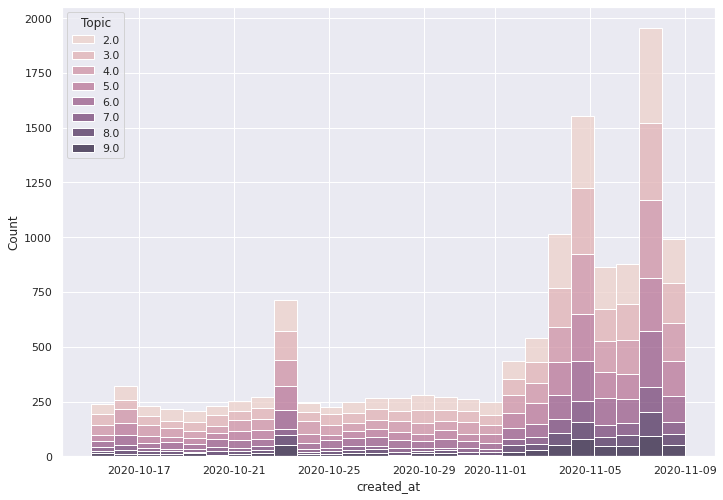

In [70]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(data=topics_df[topics_df['Topic'] < 10], x="created_at", hue="Topic", multiple="stack")

In [ ]:
model.get_topic(29)

[('abortion', 0.29019351467261634),
 ('abortions', 0.09857840626832201),
 ('prolife', 0.05174946821738719),
 ('babies', 0.036518986865424395),
 ('pro', 0.032760576740460734),
 ('aborto', 0.03242904216974435),
 ('women', 0.028168643956268374),
 ('avortement', 0.023934213155391994),
 ('unborn', 0.023658817504397283),
 ('supports', 0.022507177667671175)]

## Simple LDA Intuition Check

In [ ]:
token_list = []
tt = TweetTokenizer()
sentences = sampled['tweet'].tolist()
for t in sentences:
  tokens = tt.tokenize(str(t))
  token_list.append(tokens)


In [ ]:

dict1 = gensim.corpora.Dictionary(token_list)
# filtering out tokens that don't occur in at least 100 tweets
# but also don't occur in more than 30% of tweets 
dict1.filter_extremes(no_below=500, no_above=0.2, keep_n=100000)
# using bag of words
bow = [dict1.doc2bow(doc) for doc in token_list]
# Using 50 topics to compare again BerTopic
lda_model = gensim.models.LdaMulticore(bow, num_topics=50, id2word=dict1)

In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.065*"o" + 0.044*"trump" + 0.038*"yesterday" + 0.032*"s" + 0.032*"biden" + 0.020*"fauci" + 0.020*"polling" + 0.019*"dr" + 0.018*"source" + 0.018*"taxes"
Topic: 1 
Words: 0.042*"man" + 0.032*"know" + 0.025*"vote" + 0.024*"s" + 0.024*"voters" + 0.016*"loser" + 0.016*"people" + 0.016*"sad" + 0.015*"trump" + 0.015*"america"
Topic: 2 
Words: 0.160*"nan" + 0.039*"sick" + 0.032*"oil" + 0.027*"vote" + 0.022*"t" + 0.016*"trump" + 0.015*"y" + 0.015*"que" + 0.013*"massive" + 0.009*"s"
Topic: 3 
Words: 0.085*"en" + 0.073*"el" + 0.072*"la" + 0.053*"y" + 0.036*"los" + 0.036*"que" + 0.031*"las" + 0.020*"presidente" + 0.020*"se" + 0.020*"del"
Topic: 4 
Words: 0.042*"news" + 0.036*"biden" + 0.032*"trump" + 0.026*"media" + 0.020*"russia" + 0.019*"social" + 0.018*"power" + 0.018*"president" + 0.014*"joe" + 0.013*"dont"
Topic: 5 
Words: 0.040*"follow" + 0.034*"change" + 0.030*"kind" + 0.028*"s" + 0.027*"words" + 0.021*"trump" + 0.021*"heard" + 0.020*"remember" + 0.020*"face" + 0.019*"new

A simple Bag of Words based LDA model produced far less interpretable clusters